In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip


In [2]:
import numpy as np
import pandas as pd
import zipfile
import os
from shutil import move
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [3]:
path = "/kaggle/input/dogs-vs-cats/"
out = "/working/dogs-vs-cats/"
for p in ['train','test1']:
    zip_ref = zipfile.ZipFile(path + p +".zip", 'r')
    zip_ref.extractall(out)
    zip_ref.close()

Separating training data into dogs and cats

In [4]:
train_dir = os.path.join(out, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')


if os.path.exists(train_dogs_dir):
    for the_file in os.listdir(train_dogs_dir):
            file_path = os.path.join(train_dogs_dir, the_file)
            if os.path.isfile(file_path):
                os.unlink(file_path)
    print(f"Directory {train_dogs_dir} exists and cleaned")
else:
    os.mkdir(train_dogs_dir)
    print(f"Directory created {train_dogs_dir}")

    
if os.path.exists(train_cats_dir):
    for the_file in os.listdir(train_cats_dir):
            file_path = os.path.join(train_cats_dir, the_file)
            if os.path.isfile(file_path):
                os.unlink(file_path)
    print(f"Directory {train_cats_dir} exists and cleaned")
else:
    os.mkdir(train_cats_dir)
    print(f"Directory created {train_cats_dir}")
    
    
for path in os.listdir( train_dir):
    if 'dog' in path:
        move(os.path.join(train_dir, path), train_dogs_dir)
    else:
        move(os.path.join(train_dir, path), train_cats_dir)

Directory created /working/dogs-vs-cats/train/dogs
Directory created /working/dogs-vs-cats/train/cats


In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.3660.jpg', 'cat.9803.jpg', 'cat.8375.jpg', 'cat.6441.jpg', 'cat.918.jpg', 'cat.7264.jpg', 'cat.1123.jpg', 'cat.3255.jpg', 'cat.11075.jpg', 'cat.535.jpg']
['dog.890.jpg', 'dog.1178.jpg', 'dog.7845.jpg', 'dog.4632.jpg', 'dog.814.jpg', 'dog.2066.jpg', 'dog.8575.jpg', 'dog.1444.jpg', 'dog.9938.jpg', 'dog.11532.jpg']


In [6]:
test_dir = out+'/test1' 
test_fnames = os.listdir(test_dir )
test_fnames[:5]

['10435.jpg', '6790.jpg', '4644.jpg', '1835.jpg', '1102.jpg']

In [7]:
ind = 0

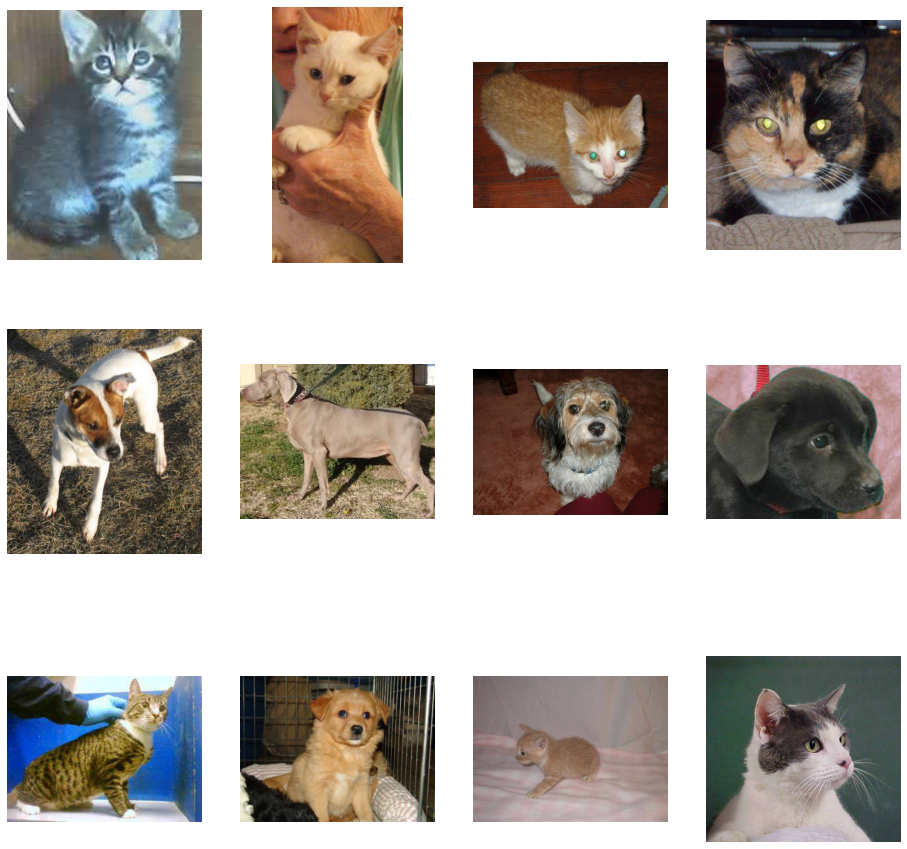

In [8]:
fig = plt.gcf()
fig.set_size_inches(4*4, 4*4)
ind += 4

dogs_dr = [os.path.join(train_dogs_dir, dname) for dname in train_dog_fnames[ind-4: ind]]
cats_dr = [os.path.join(train_cats_dir, cname) for cname in train_cat_fnames[ind-4: ind]]
test_dr = [os.path.join(test_dir, name) for name in test_fnames[ind-4: ind]]

for i, img_path in enumerate(cats_dr+dogs_dr+test_dr):
    fig = plt.subplot(3, 4, i+1)
    fig.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [10]:
class Mycallbacks(tf.keras.callbacks.Callback):
    def Callbacks(self, epochs, logs={}):
        if (logs.get('acc')>0.9):
            print("Reached 90% accuracy")
            self.mode.stop_training == True

callbacks = Mycallbacks()

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy']
             )

In [11]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=30,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) 

# test_datagen = ImageDataGenerator(rescale=1/255)
# test_generator =  test_datagen.flow_from_directory(test_dir,
#                                                  batch_size=20,
#                                                  class_mode  = 'binary',
#                                                  target_size = (150, 150))

Found 25000 images belonging to 2 classes.


In [12]:
m1 = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=20,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/20
10/10 [==============================] - 8s 831ms/step - loss: 1.9395 - accuracy: 0.5233
Epoch 2/20
10/10 [==============================] - 8s 846ms/step - loss: 0.6990 - accuracy: 0.5033
Epoch 3/20
10/10 [==============================] - 9s 851ms/step - loss: 0.6894 - accuracy: 0.5633
Epoch 4/20
10/10 [==============================] - 8s 793ms/step - loss: 0.7152 - accuracy: 0.5600
Epoch 5/20
10/10 [==============================] - 8s 832ms/step - loss: 0.6996 - accuracy: 0.5533
Epoch 6/20
10/10 [==============================] - 8s 800ms/step - loss: 0.6919 - accuracy: 0.5267
Epoch 7/20
10/10 [==============================] - 8s 796ms/step - loss: 0.7330 - accuracy: 0.5467
Epoch 8/20
10/10 [==============================] - 8s 842ms/step - loss: 0.7341 - accuracy: 0.5467
Epoch 9/20
10/10 [==============================] - 8s 827ms/step - loss: 0.6797 - accuracy: 0.5633
Epoch 10/20
10/10 [==============================] - 8s 803ms/step - loss: 0.6816 - accuracy: 0.5500

In [13]:
test_pred = []
for i, img in enumerate(test_fnames):
    img = os.path.join(test_dir, img)
    img = image.load_img(img, target_size=(150,150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.vstack([img])
    classes = model.predict(img, batch_size=10)
    if classes[0]>0:
        test_pred.append('dog')
    else:
        test_pred.append('cat')
    if i%1000 == 0:
        print(f"Predicted {i}")

Predicted 0
Predicted 1000
Predicted 2000
Predicted 3000
Predicted 4000
Predicted 5000
Predicted 6000
Predicted 7000
Predicted 8000
Predicted 9000
Predicted 10000
Predicted 11000
Predicted 12000


In [14]:
sampleSubmission = pd.read_csv("/kaggle/input/dogs-vs-cats/sampleSubmission.csv")
sampleSubmission.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [15]:
sampleSubmission.label = test_pred

sampleSubmission.to_csv("sampleSubmission.csv", index=False)

In [16]:
ind=0

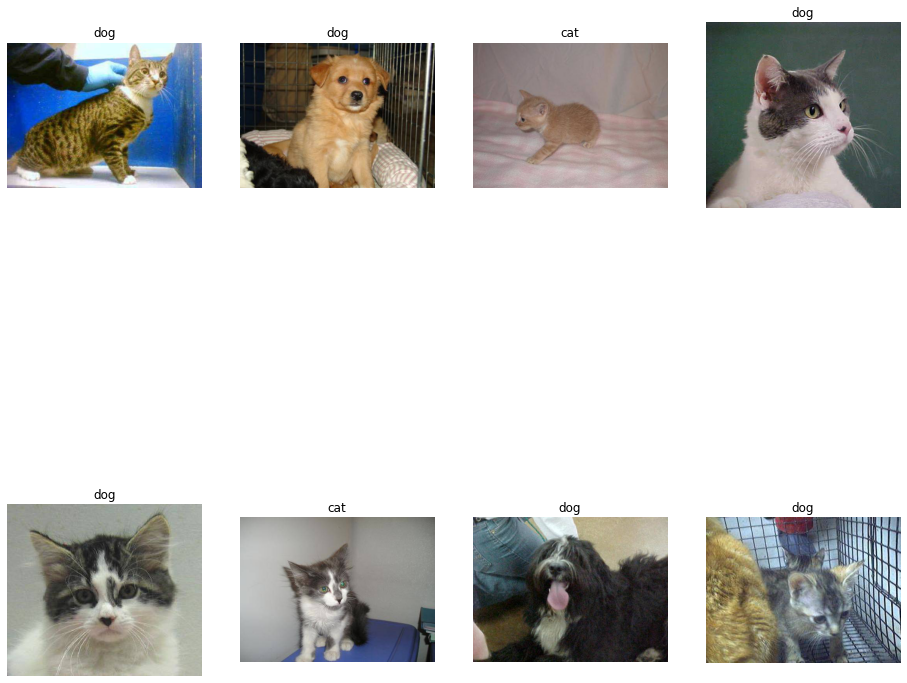

In [17]:
fig = plt.gcf()
fig.set_size_inches(4*4, 4*4)
ind += 8

test_dr = [os.path.join(test_dir, name) for name in test_fnames[ind-8: ind]]

for i, img_path in enumerate(test_dr):
    fig = plt.subplot(2, 4, i+1)
    fig.axis('Off')
    img = mpimg.imread(img_path)
    plt.title(test_pred[i])
    plt.imshow(img)

plt.show()

To be improved